#**EXP 1**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes trl safetensors torch --no-cache

In [ ]:
import pandas as pd
import json
from datasets import load_dataset

# Define your base path and file locations
base_path = '/content/drive/My Drive/Colab Notebooks/CSCI 564 NLP'
csv_path = f'{base_path}/hindi_data/romanized_hindi_english_paper.csv'
json_path = f'{base_path}/hindi_data/romanized_hindi_english_paper_formatted.json'

In [ ]:
# Assuming df is your pandas DataFrame
column_names = ['H', 'RH', 'E']
df = pd.read_csv(csv_path, names=column_names, header=0, nrows=8000)
df['RH'] = df['RH'].astype(str)
df['E'] = df['E'].astype(str)
df = df.dropna()
# Convert DataFrame rows to desired format, focusing on 'RH' (Romanized Hindi) and 'E' (English)
formatted_list = df.apply(lambda row: {'hindi': row['RH'], 'english': row['E']}, axis=1).tolist()

# Save the formatted list as a JSON file
with open(json_path, 'w') as f:
    json.dump(formatted_list, f)

Generating train split: 0 examples [00:00, ? examples/s]

Training dataset sample: {'english': 'king of diamonds', 'hindi': 'int kaa badshah'}
Evaluation dataset sample: {'english': '_ Fullscreen', 'hindi': 'fullscreen (_ f)'}


In [ ]:
# Load the dataset from the JSON file
dataset = load_dataset("json", data_files=json_path, split="train")

# Split the dataset into training and evaluation datasets with an 80/20 split
train_dataset = dataset.train_test_split(test_size=0.2)["train"]
eval_dataset = dataset.train_test_split(test_size=0.2)["test"]

# The train_dataset and eval_dataset are now available for use
print("Training dataset sample:", train_dataset[0])
print("Evaluation dataset sample:", eval_dataset[0])

Training dataset sample: {'english': 'Save message', 'hindi': 'yeah sandesh bhejen'}
Evaluation dataset sample: {'english': 'This game does not have hint support yet.', 'hindi': 'iss khel main abb taka koi sanket samarthan upalabdh nahin hai.'}


In [ ]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [ ]:
def formatting_func(example):
    text = f"### Romanized Hindi: {example['hindi']}\n ### English: {example['english']}"
    return text

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/6399 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

7999


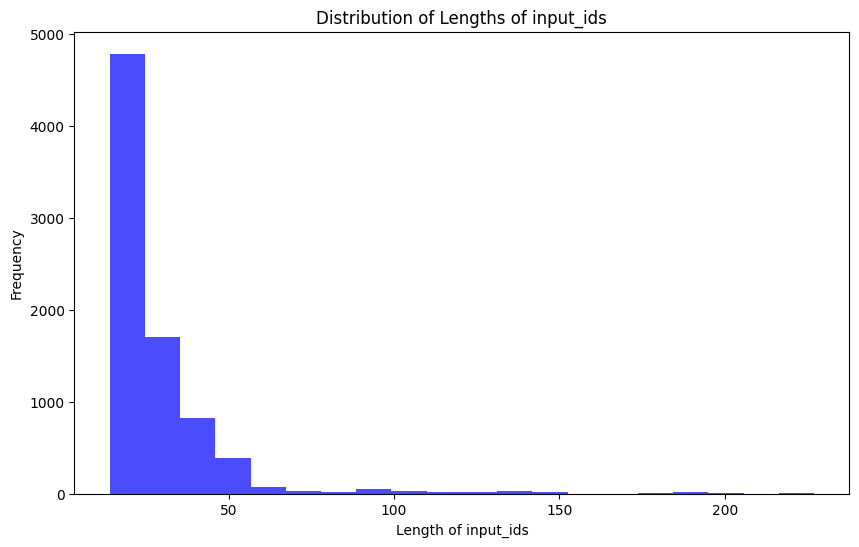

In [ ]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [ ]:
max_length = 256 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [ ]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/6399 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

### How does the model performs?

In [ ]:
eval_prompt = """ Translate the following sentences from Hindi to English. The output should be in English and no other language.
### Romanized Hindi: vidhi
### English:"""

In [ ]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


 Translate the following sentences from Hindi to English. The output should be in English and no other language.
### Romanized Hindi: vidhi
### English: rule


In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)


In [ ]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        # report_to="wand÷b",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
25,3.142000,2.216603
50,1.967100,1.892830
75,1.908900,1.721756
100,1.530700,1.627403
125,1.609900,1.544060
150,1.428000,1.481639
175,1.662200,1.410243
200,1.537800,1.363004
225,1.287900,1.314901
250,1.317700,1.287571


/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in

TrainOutput(global_step=500, training_loss=1.4485468292236328, metrics={'train_runtime': 6295.6623, 'train_samples_per_second': 0.159, 'train_steps_per_second': 0.079, 'total_flos': 1.1052597116928e+16, 'train_loss': 1.4485468292236328, 'epoch': 0.16})

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/Colab Notebooks/CSCI 564 NLP/mistral-journal-finetune/checkpoint-500")

In [ ]:
eval_prompt = "### Romanized Hindi: ack say adhik widget focus main hai\n### English:"
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=50, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


### Romanized Hindi: ack say adhik widget focus main hai
### English: more than one focused widgets defocus publictext publictext publictext
### Chinese:  publictext public text public text public text
### French:  _ Focus public text
### Italian: _ Focus pubblico testo
### Russian:


In [ ]:
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu

# Assume test_data is a list of tuples: (source_sentence, reference_translation)

sources = eval_dataset['hindi']
references = eval_dataset['english']

In [ ]:
trans = []
refs = []

ft_model.eval()
for i in range(len(sources)):
    eval_prompt = f"### Romanized Hindi: {sources[i]}\n### English:"
    model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
      outputs = ft_model.generate(**model_input, max_new_tokens=50, repetition_penalty=1.15)[0]
      text = eval_tokenizer.decode(outputs, skip_special_tokens=True)
      t = text.split("\n### English: ")
      t = t[1]. split("\n")[0]
      trans.append(t.split())
      refs.append(references[i].split())  # Note: reference must be a list of lists for corpus_bleu

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

KeyboardInterrupt: 

In [ ]:
print(trans[7])
print(refs[7])

['Move', '~', 'a', 'onto', 'the', 'unknown', 'card.']
['Move', '~', 'a', 'onto', 'the', 'unknown', 'card.']


In [ ]:
score = corpus_bleu(refs, trans, weights=[0.0, 0.25, 0.25, 0.0])
scores = []

avg = 0

for i in trans:
  # score = sentence_bleu(r, i, weights=[0.001,0.001,0,0])
  score = sentence_bleu(refs, i, weights=[0.25,0.001,0,0]) # unigram, bigram, trigram, quadrigram
  scores.append(score)
  avg += score

avg = avg/len(trans)
print(scores)
print("Average BLEU score: ", avg)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

[0.44496364554426016, 0.28430645296078766, 0.9027744206798209, 0.4140853306672728, 0.8221911415088685, 0, 0.37416833445639286, 1.0, 0.9029758914477024, 0.4772472098481303, 0.9029758914477024, 0.44496364554426016, 0.37416833445639286, 1.0, 0, 1.0, 0.45826074866259997, 0, 0.4924332214477753, 0.9295830465586772, 0.9133164869518604, 1.0, 0.45826074866259997, 0.9454695752285901, 0.37416833445639286, 0.9993070929904525, 0, 0.858006684437339, 0.8920792957788916, 1.0, 1.0, 1.0, 0, 0.39843102447353995, 0, 0.4924332214477753, 0.46571458717863623, 0.9611389588891094, 0.44496364554426016, 0.9638642340599155, 1.0, 1.0, 0.7582572934179451, 0.4140853306672728, 1.0, 0.4140853306672728, 0.27355837777461683, 0.4924332214477753, 0, 0.37416833445639286, 0.8795019012017843, 0, 1.0, 0.3916177268898787, 0.28430645296078766, 0.8873304756423315, 0.4140853306672728, 0.4140853306672728, 0.4140853306672728, 0.3104125402631453, 0, 0.44496364554426016, 0.8574121655914537, 0.4140853306672728, 0.9618054005930009, 1.0

In [ ]:
peft_trainer.save_model('/content/drive/My Drive/CSCI544ProjOutput/saved_model')
tokenizer.save_pretrained('/content/drive/My Drive/CSCI544ProjOutput/saved_tokenizer')